In [170]:
# Needs hdf5 to run
# Instead of hf datasets lib alternatively use torchgeo 
# As of 02.11.24 failed to reach geo API, could attempt later
%pip install --upgrade torch; torchvision; datasets; h5py

Defaulting to user installation because normal site-packages is not writeable
zsh:1: command not found: torchvision
zsh:1: command not found: datasets
zsh:1: command not found: h5py
Note: you may need to restart the kernel to use updated packages.


In [171]:
# Copyright 2020 The HuggingFace Datasets Authors and the current dataset script contributor.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
from typing import List
import torch
import datasets
# from torchgeo.datasets import CaBuAr
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import h5py
import numpy as np

# Find for instance the citation on arxiv or on the dataset repo/website
_CITATION = """\
@article{cabuar,
  title={Ca{B}u{A}r: California {B}urned {A}reas dataset for delineation},
  author={Rege Cambrin, Daniele and Colomba, Luca and Garza, Paolo},
  journal={IEEE Geoscience and Remote Sensing Magazine},
  doi={10.1109/MGRS.2023.3292467},
  year={2023}
}
"""

# You can copy an official description
_DESCRIPTION = """\
CaBuAr dataset contains images from Sentinel-2 satellites taken before and after a wildfire.
The ground truth masks are provided by the California Department of Forestry and Fire Protection and they are mapped on the images.
"""

_HOMEPAGE = "https://huggingface.co/datasets/DarthReca/california_burned_areas"

_LICENSE = "OPENRAIL"

# Define the root directory for the dataset
# Change manually
_URLS = {'root': os.curdir,'cache_dir':"/raw"}
_BATCH_SIZE = 16
_NUM_WORKERS = 0


In [172]:
# Set the Hugging Face datasets cache directory
os.environ['HF_DATASETS_CACHE'] = os.path.join(_URLS['root'],_URLS['cache_dir'])


# You can verify by printing (optional)
print(f"HF_DATASETS_CACHE set to: {os.getenv('HF_DATASETS_CACHE')}")

HF_DATASETS_CACHE set to: /raw


In [173]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [174]:
# Load the CaBuAr dataset
# Possible splits: 1-5, or chabud
# For docs check out 
# https://huggingface.co/datasets/DarthReca/california_burned_areas
# https://torchgeo.readthedocs.io/en/stable/api/datasets.html#cabuar 
dataset = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split='chabud',trust_remote_code=True)


In [175]:
# Define transformations (modify as needed)
transform = transforms.Compose([
    transforms.Lambda(np.array), # List converts to numpy array
    transforms.ToTensor(),  # Converts numpy arrays to torch tensors
    # Add more transforms if necessary, e.g., normalization
    # transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [176]:
# Define a custom PyTorch Dataset to apply transformations
class CaBuArPyTorchDataset(datasets.GeneratorBasedBuilder):
    def __init__(self, hf_dataset, transform=None, load_prefire=True):
    # Commented - Alternative def using torchgeo parent class
    #def __init__(self, root, transform=None, download = False):
        """
        Args:
            hf_dataset: Hugging Face dataset object
            transform: Optional transform to be applied on a sample
            load_prefire: Boolean indicating whether to load pre_fire data
            download: if True, download dataset and store it in the root directory
        """
        # super().__init__(root=root, transforms=transform, download=download)
        self.hf_dataset = hf_dataset
        self.transform = transform
        self.load_prefire = load_prefire

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        sample = self.hf_dataset[idx]
        post_fire = sample['post_fire']  # Shape: (512, 512, 12)
        mask = sample['mask']            # Shape: (512, 512, 1)

        if self.load_prefire:
            pre_fire = sample.get('pre_fire', np.zeros_like(post_fire))
        else:
            pre_fire = None

        # Apply transformations
        if self.transform:
            post_fire = self.transform(post_fire)
            mask = self.transform(mask)
            if pre_fire is not None:
                pre_fire = self.transform(pre_fire)

        # Move tensors to device
        post_fire = post_fire.to(device)
        mask = mask.to(device)
        if pre_fire is not None:
            pre_fire = pre_fire.to(device)

        # Prepare the output dictionary
        if self.load_prefire:
            return {
                'post_fire': post_fire,    # Tensor: [12, 512, 512]
                'pre_fire': pre_fire,      # Tensor: [12, 512, 512]
                'mask': mask.squeeze(0)    # Tensor: [512, 512]
            }
        else:
            return {
                'post_fire': post_fire,    # Tensor: [12, 512, 512]
                'mask': mask.squeeze(0)    # Tensor: [512, 512]
            }

In [177]:
# Instantiate the custom dataset
pytorch_dataset = CaBuArPyTorchDataset(
    hf_dataset=dataset,
    transform=transform,
    load_prefire=True  # Set to False if you want to load only post_fire data
)
# pytorch_dataset = CaBuArPyTorchDataset(
#     root= _URLS['root'],
#     transform=transform,
#     download = False  # Set to False if you want to load only post_fire data
# )
# Create a DataLoader
dataloader = DataLoader(
    pytorch_dataset,
    batch_size=_BATCH_SIZE,       # Adjust batch size as needed
    shuffle=False,        # Shuffle for training
    num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
    pin_memory=True      # Speed up transfer to GPU
)

In [178]:
# Example: Iterate through the DataLoader
for batch_idx, batch in enumerate(dataloader):
    post_fire = batch['post_fire']      # Shape: [batch_size, 12, 512, 512]
    mask = batch['mask']                # Shape: [batch_size, 512, 512]
    pre_fire = batch.get('pre_fire')    # Shape: [batch_size, 12, 512, 512] or None

    # Now you can pass `post_fire`, `pre_fire`, and `mask` to your model
    # Example:
    # outputs = model(post_fire, pre_fire)
    # loss = criterion(outputs, mask)

    # For demonstration, we'll just print the batch shapes
    print(f"Batch {batch_idx}:")
    print(f"  post_fire shape: {post_fire.shape}")
    if pre_fire is not None:
        print(f"  pre_fire shape: {pre_fire.shape}")
    print(f"  mask shape: {mask.shape}")

    # Break after first batch for demonstration
    if batch_idx == 0:
        break

Batch 0:
  post_fire shape: torch.Size([16, 12, 512, 512])
  pre_fire shape: torch.Size([16, 12, 512, 512])
  mask shape: torch.Size([16, 512, 512])


# TODO
 - Create an class ratio graphic in output mask

 - **(Optional)** showcase density of classes on mask (how noisy is the data)

 - Extract spectre distribution on random images

 - Mean brightness, distribution from center of inputs

 - how **correlated** are adjacent 2d tensors in pre-fire, post-fire, could dataset be ordered by **time** if needed? 

In [179]:
# (Optional) Collect accuracy vector after training epochs
# Here, it's assumed you have a training loop where you collect accuracy

# Example training loop structure
def train_model(dataloader, model, criterion, optimizer, num_epochs=10):
    loss_vector = []
    accuracy_vector = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in dataloader:
            post_fire = batch['post_fire']
            mask = batch['mask']
            pre_fire = batch.get('pre_fire')

            # Move data to device
            post_fire = post_fire.to(device)
            mask = mask.to(device)
            if pre_fire is not None:
                pre_fire = pre_fire.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(post_fire, pre_fire) if pre_fire is not None else model(post_fire)
            loss = criterion(outputs, mask)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * post_fire.size(0)
            # Assuming outputs are logits; apply argmax to get predictions
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == mask).sum().item()
            total += mask.numel()

        epoch_loss = running_loss / len(pytorch_dataset)
        epoch_acc = 100. * correct / total
        loss_vector.append(epoch_loss)
        accuracy_vector.append(epoch_acc)

        print(f"Epoch {epoch}/{num_epochs}: Loss={epoch_loss:.4f}, Accuracy={epoch_acc:.2f}%")

    print("Training complete.")
    print("Accuracy vector:", accuracy_vector)
    return loss_vector, accuracy_vector

# EDA


Total pre_fire images: 68
Total post_fire images: 68
Total masks: 68
Class distribution in masks:
  Class 0: 13355888 pixels (74.92%)
  Class 1: 4469904 pixels (25.08%)


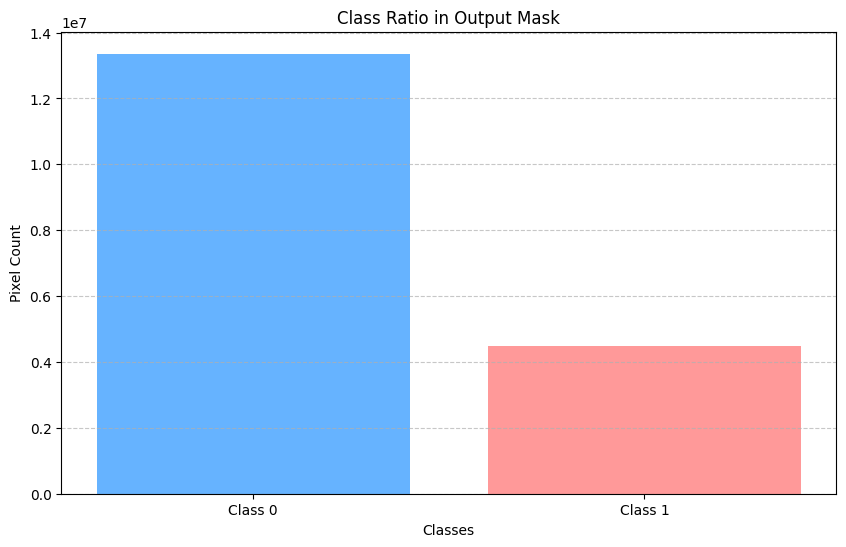

In [180]:
class_counts = {0: 0, 1: 0}
total_masks = 0
total_pre_fire = 0
total_post_fire = 0

for batch_idx, batch in enumerate(dataloader):
    masks = batch['mask'] 
    total_masks += len(masks)  # count masks 
    total_pre_fire += batch['pre_fire'].size(0)  # count pre_fire
    total_post_fire += batch['post_fire'].size(0)  # count post_fire
    for mask in masks: # pixel count
        mask = mask.cpu().numpy()
        unique, counts = np.unique(mask, return_counts=True)
        for cls, count in zip(unique, counts):
            class_counts[cls] += count


total_pixels = sum(class_counts.values())

# preparation for graphics
classes = [f'Class {cls}' for cls in class_counts.keys()]
pixel_counts = list(class_counts.values())

# show result
print(f"Total pre_fire images: {total_pre_fire}")
print(f"Total post_fire images: {total_post_fire}")
print(f"Total masks: {total_masks}")
print(f"Class distribution in masks:")
for cls, count in class_counts.items():
    print(f"  Class {cls}: {count} pixels ({100 * count / total_pixels:.2f}%)")

# create bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, pixel_counts, color=['#66b3ff', '#ff9999'])
plt.xlabel('Classes')
plt.ylabel('Pixel Count')
plt.title('Class Ratio in Output Mask')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Дисбаланс класів вказує на те, що модель може бути неоптимально налаштована для класифікації класу 1 (пожежа), тому важливо провести додаткові кроки для балансування цього дисбалансу перед навчанням моделі:

- Зважування класів
- Збільшення кількості зразків для меншого класу або зменшення для другуго, більшого класу
- Препроценсинг

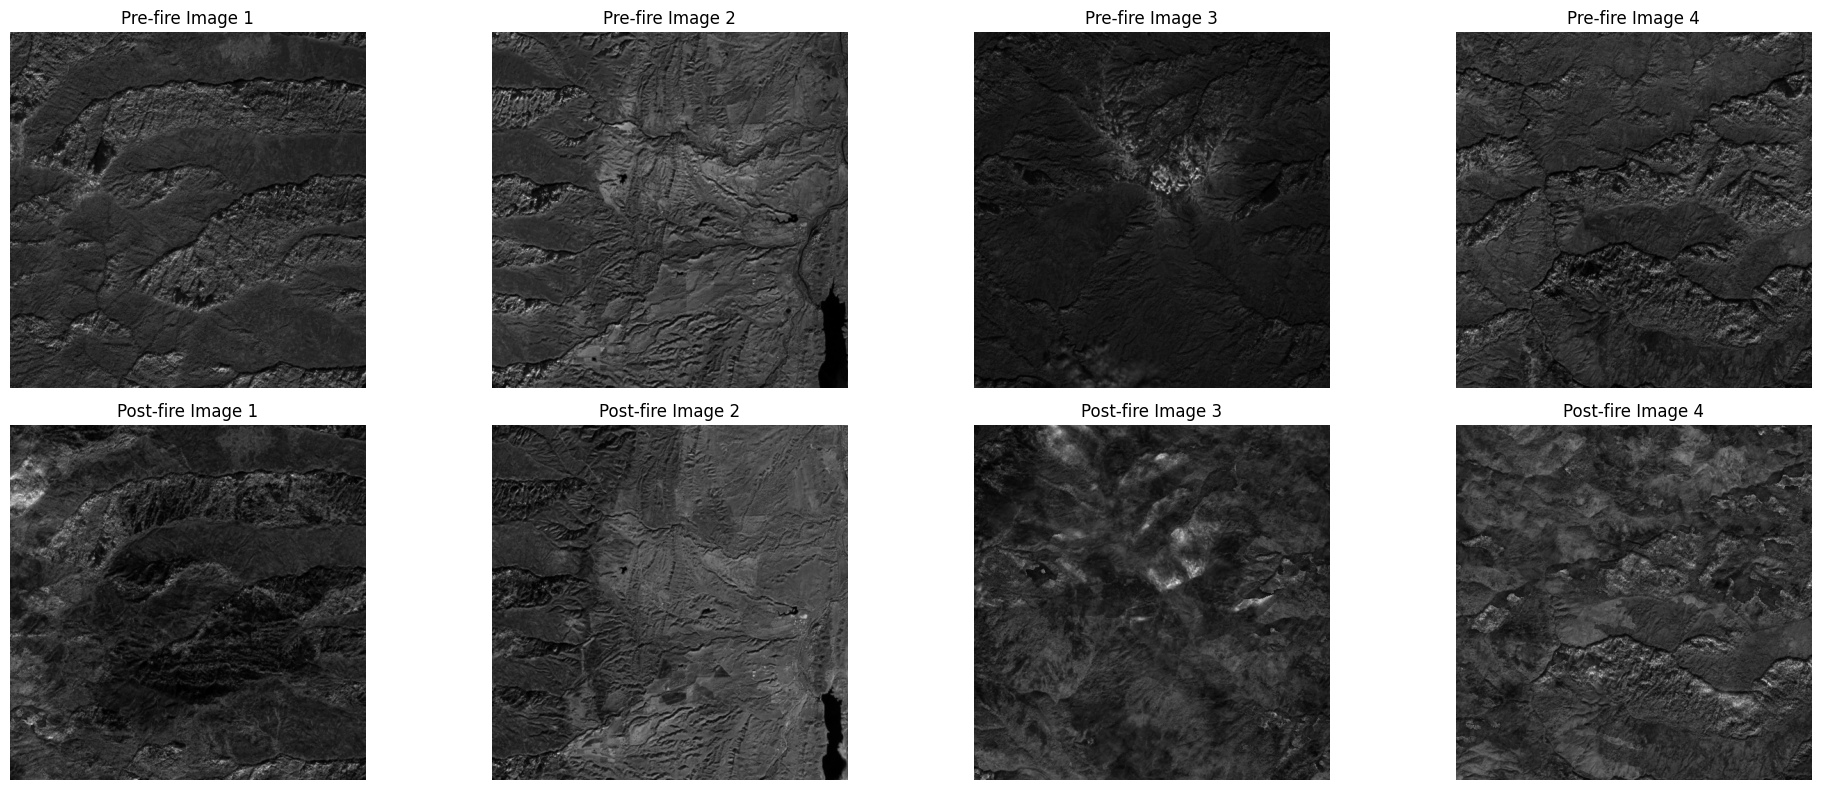

In [193]:
post_fire_images = batch['post_fire']
pre_fire_images = batch['pre_fire']
channel = 5

# image count
num_images = min(12, len(post_fire_images))

fig, axes = plt.subplots(2, num_images, figsize=(20, 8))

# show first images pre_fire
for i in range(num_images):
    pre_fire_image = pre_fire_images[i][channel].cpu().numpy()
    axes[0, i].imshow(pre_fire_image, cmap='gray')
    axes[0, i].set_title(f'Pre-fire Image {i + 1}')
    axes[0, i].axis('off')

# show first images post_fire
for i in range(num_images):
    post_fire_image = post_fire_images[i][channel].cpu().numpy()
    axes[1, i].imshow(post_fire_image, cmap='gray')
    axes[1, i].set_title(f'Post-fire Image {i + 1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


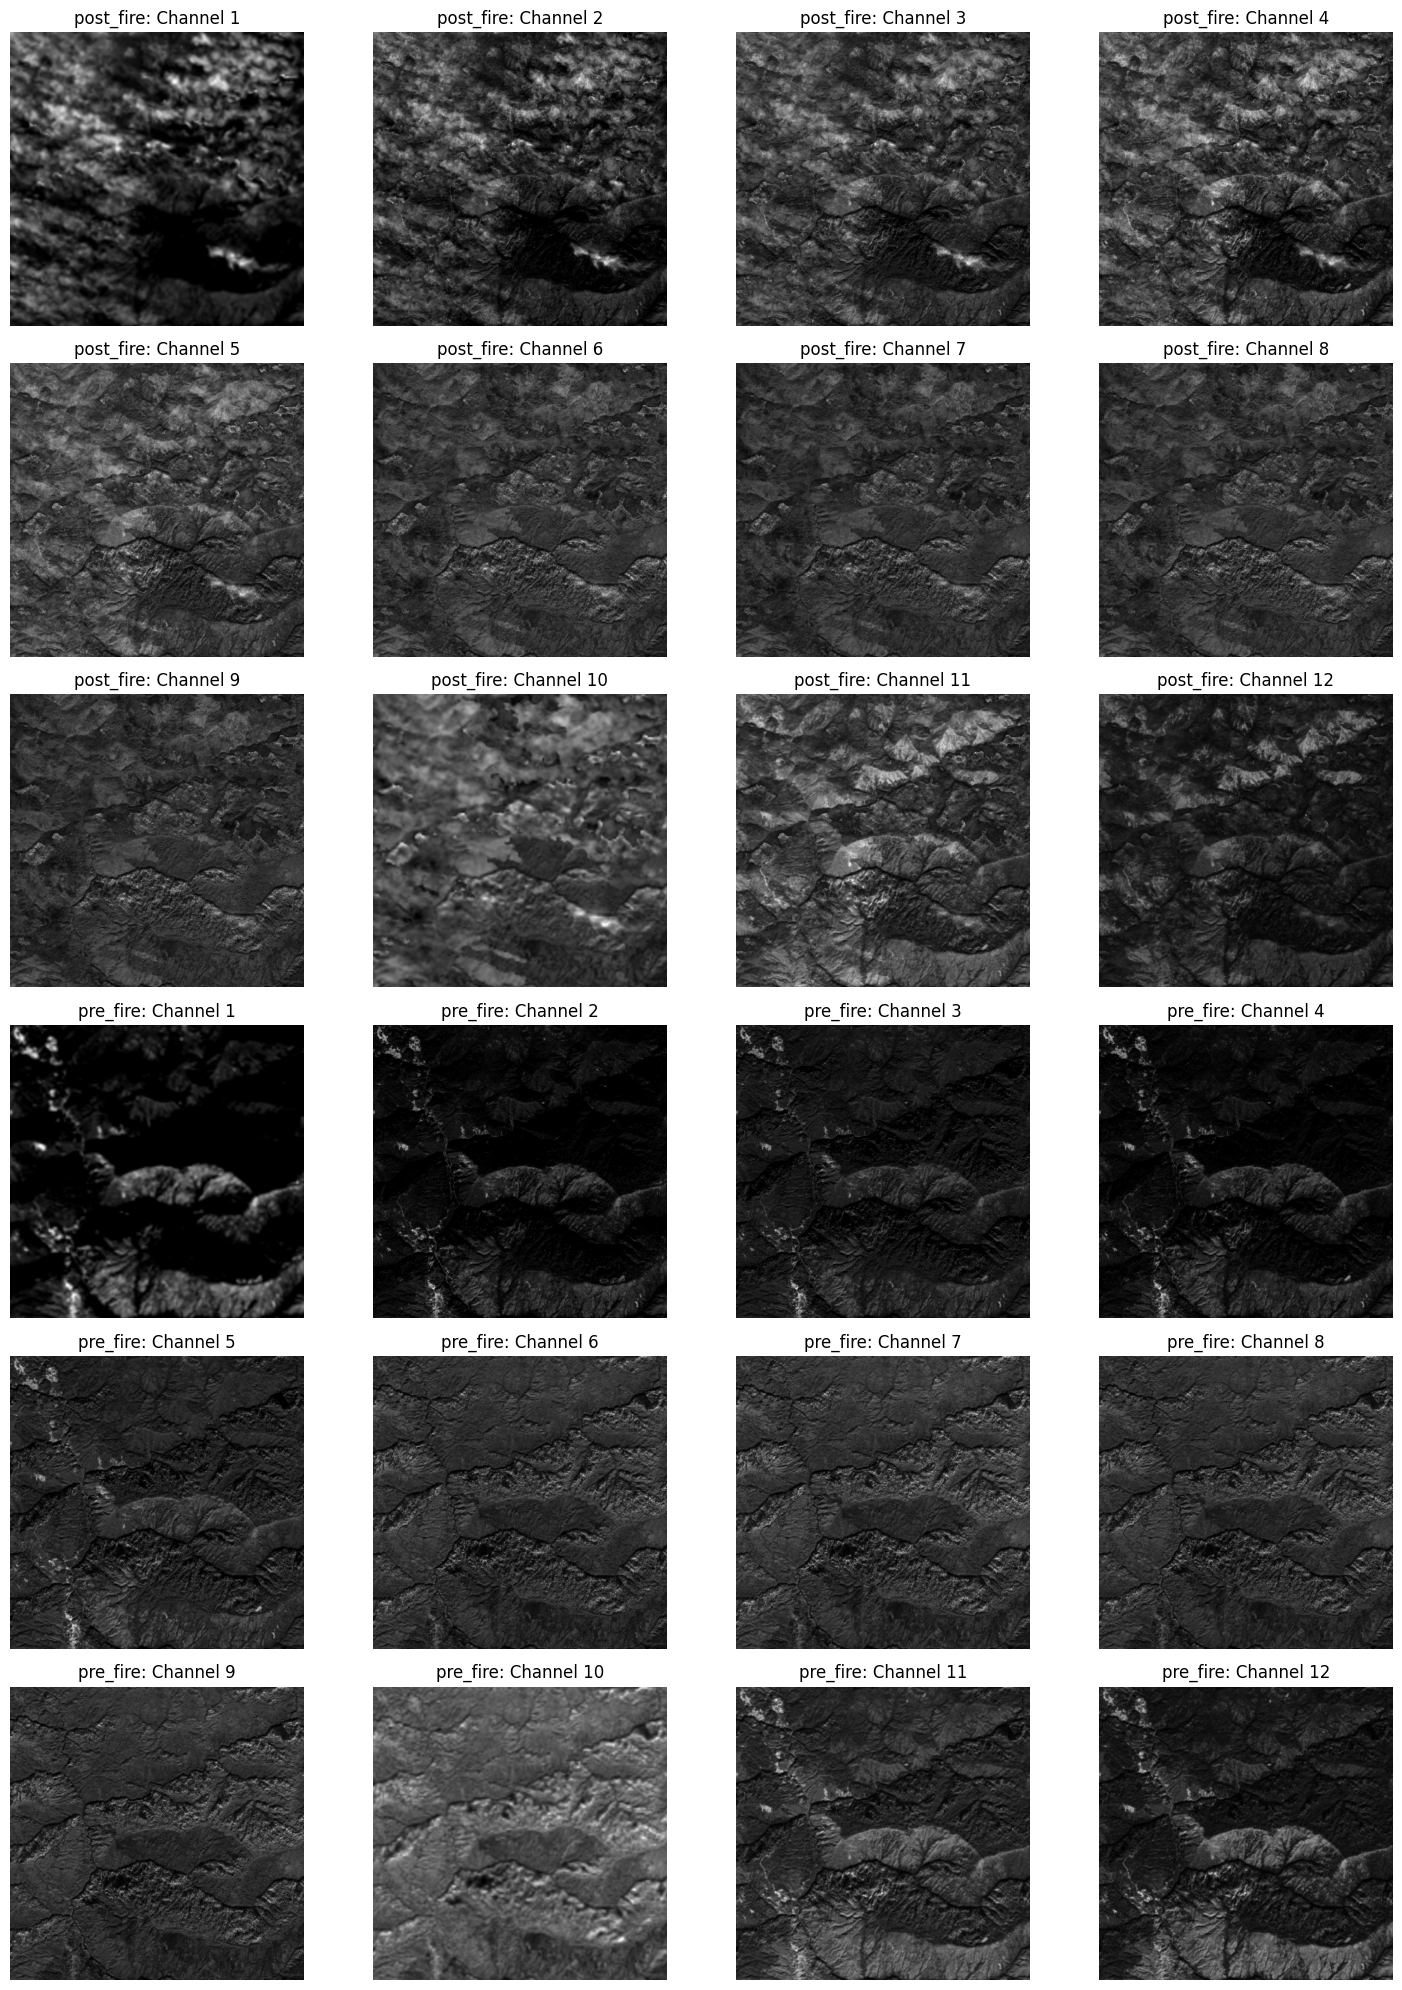

In [182]:
# chose one image from batch
post_fire_image = batch['post_fire'][3].cpu().numpy()
pre_fire_image = batch['pre_fire'][3].cpu().numpy()

fig, axes = plt.subplots(6, 4, figsize=(15, 20))

# show post_fire channels
for i in range(12):
    ax = axes[i // 4, i % 4]
    ax.imshow(post_fire_image[i], cmap='gray')
    ax.set_title(f'post_fire: Channel {i + 1}')
    ax.axis('off')

# show pre_fire channels 
for i in range(12):
    ax = axes[(i + 12) // 4, (i + 12) % 4]
    ax.imshow(pre_fire_image[i], cmap='gray')
    ax.set_title(f'pre_fire: Channel {i + 1}')
    ax.axis('off')
    
plt.tight_layout()
plt.show()


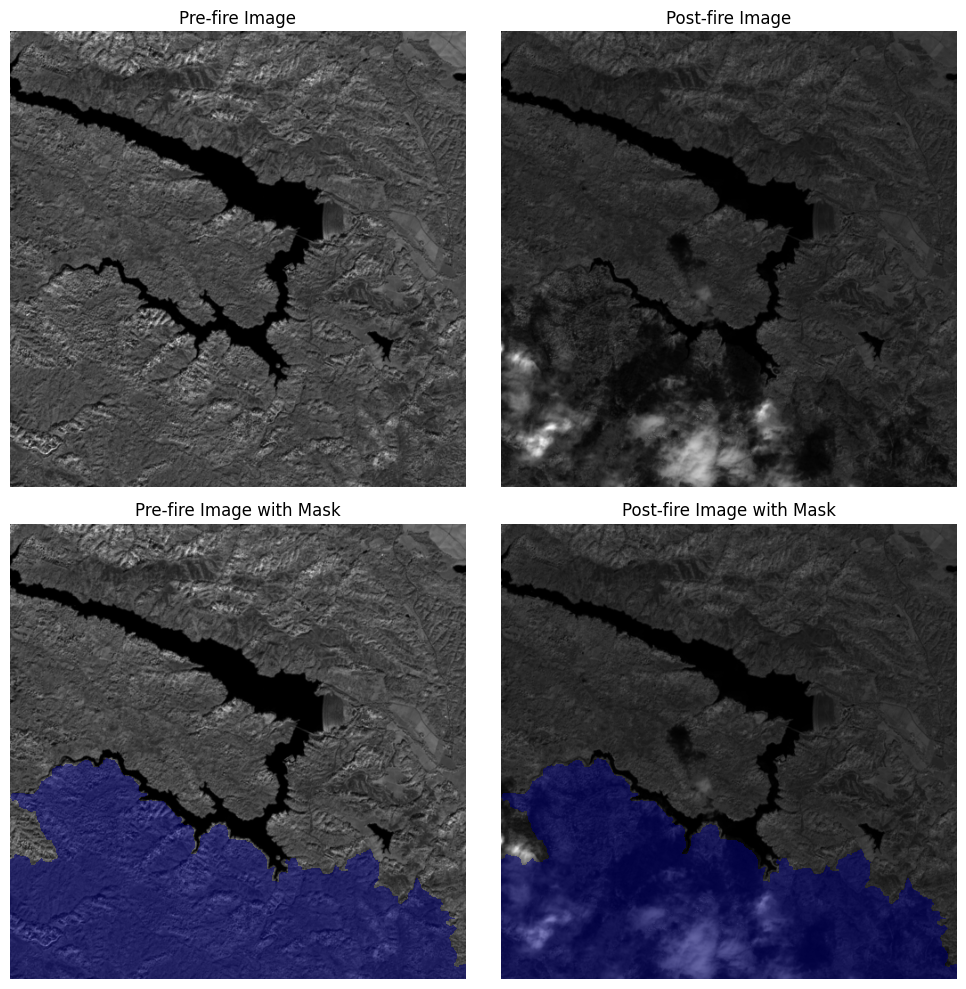

In [183]:
for batch_idx, batch in enumerate(dataloader):

    # chose images and mask
    post_fire_image = batch['post_fire'][11][5].cpu().numpy()
    pre_fire_image = batch['pre_fire'][11][5].cpu().numpy()
    mask = batch['mask'][11].cpu().numpy()

    mask_true = np.ma.masked_where(mask == 0, mask)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

    # Pre-fire image
    axes[0, 0].imshow(pre_fire_image, cmap='gray')
    axes[0, 0].set_title('Pre-fire Image', fontsize=12)
    axes[0, 0].axis('off')

    # Post-fire image
    axes[0, 1].imshow(post_fire_image, cmap='gray')
    axes[0, 1].set_title('Post-fire Image', fontsize=12)
    axes[0, 1].axis('off')

    # Pre-fire image with mask
    axes[1, 0].imshow(pre_fire_image, cmap='gray')
    axes[1, 0].imshow(mask_true, cmap='jet', alpha=0.5)
    axes[1, 0].set_title('Pre-fire Image with Mask', fontsize=12)
    axes[1, 0].axis('off')
 
    # Post-fire image with mask
    axes[1, 1].imshow(post_fire_image, cmap='gray')
    axes[1, 1].imshow(mask_true, cmap='jet', alpha=0.5)
    axes[1, 1].set_title('Post-fire Image with Mask', fontsize=12)
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Stop in first batch
    break


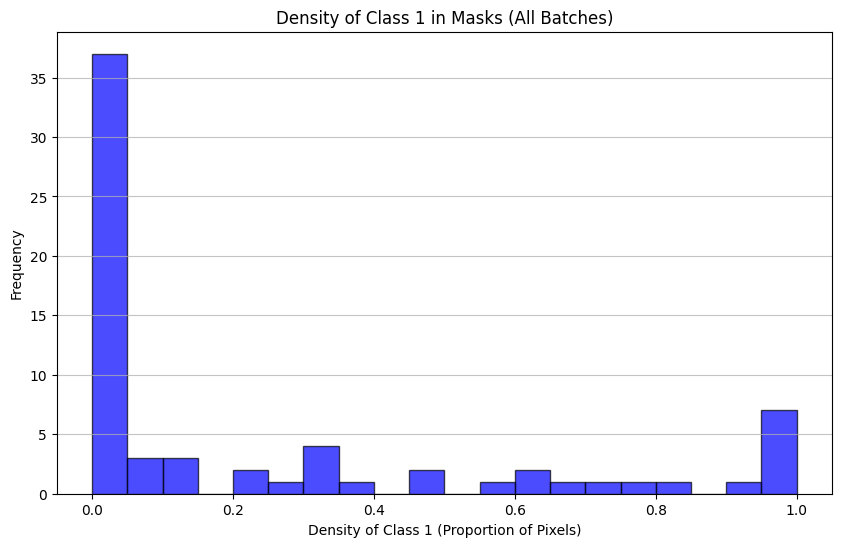

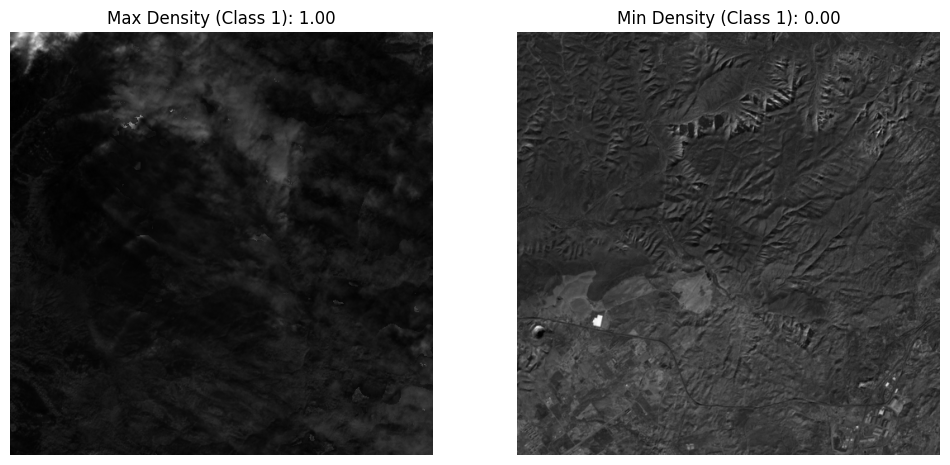

In [184]:
all_densities = []
all_post_fire_images = []

# go for all batches
for batch_idx, batch in enumerate(dataloader):

    masks = batch['mask']
    post_fire_images = batch['post_fire']

    densities = []

    # Calculate densities for each image in batch
    for i in range(masks.size(0)):
        mask = masks[i].cpu().numpy()
        post_fire_image = post_fire_images[i].cpu().numpy()

        class_1_density = np.sum(mask == 1) / mask.size  # Divide true mask on all mask pixels
        densities.append(class_1_density)

    # add data to arrays
    all_densities.extend(densities)
    all_post_fire_images.extend(post_fire_images.cpu().numpy())

# Density of Class True in Masks
plt.figure(figsize=(10, 6))
plt.hist(all_densities, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Density of Class 1 (Proportion of Pixels)')
plt.ylabel('Frequency')
plt.title('Density of Class 1 in Masks (All Batches)')
plt.grid(axis='y', alpha=0.75)
plt.show()

# find idx for max and min densities
max_density_idx = np.argmax(all_densities)
min_density_idx = np.argmin(all_densities)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Image with max densities
max_post_fire_image = all_post_fire_images[max_density_idx]
axes[0].imshow(max_post_fire_image[5], cmap='gray')
axes[0].set_title(f'Max Density (Class 1): {all_densities[max_density_idx]:.2f}')
axes[0].axis('off')

# Image with min densities
min_post_fire_image = all_post_fire_images[min_density_idx]
axes[1].imshow(min_post_fire_image[5], cmap='gray')
axes[1].set_title(f'Min Density (Class 1): {all_densities[min_density_idx]:.2f}')
axes[1].axis('off')

plt.show()

Майже половина масок має дуже низьку щільність класу 1 (пожежі), 7 масок майже повністю заповнені пожежою, а решта 30% масок мають щільність пожеж в діапазоні від 0.1 до 0.8.

Таким чином, у датасеті є зображення, на яких пожежа займає майже всю площу маски, а є й такі, де її присутність мінімальна або зовсім відсутня. Це дає нам цікаву можливість дослідити різницю між такими зображеннями. Можливо, зображення з високою щільністю будуть значно темнішими через чорний колір (як наслідок вугілля або згорілих елементів). Водночас, зображення з низькою щільністю пожежі, ймовірно, будуть світлішими. Це може бути важливим фактором для навчання моделі, оскільки різниця в яскравості між такими зображеннями може бути корисною ознакою для розпізнавання пожеж або пост-пожежних змін.

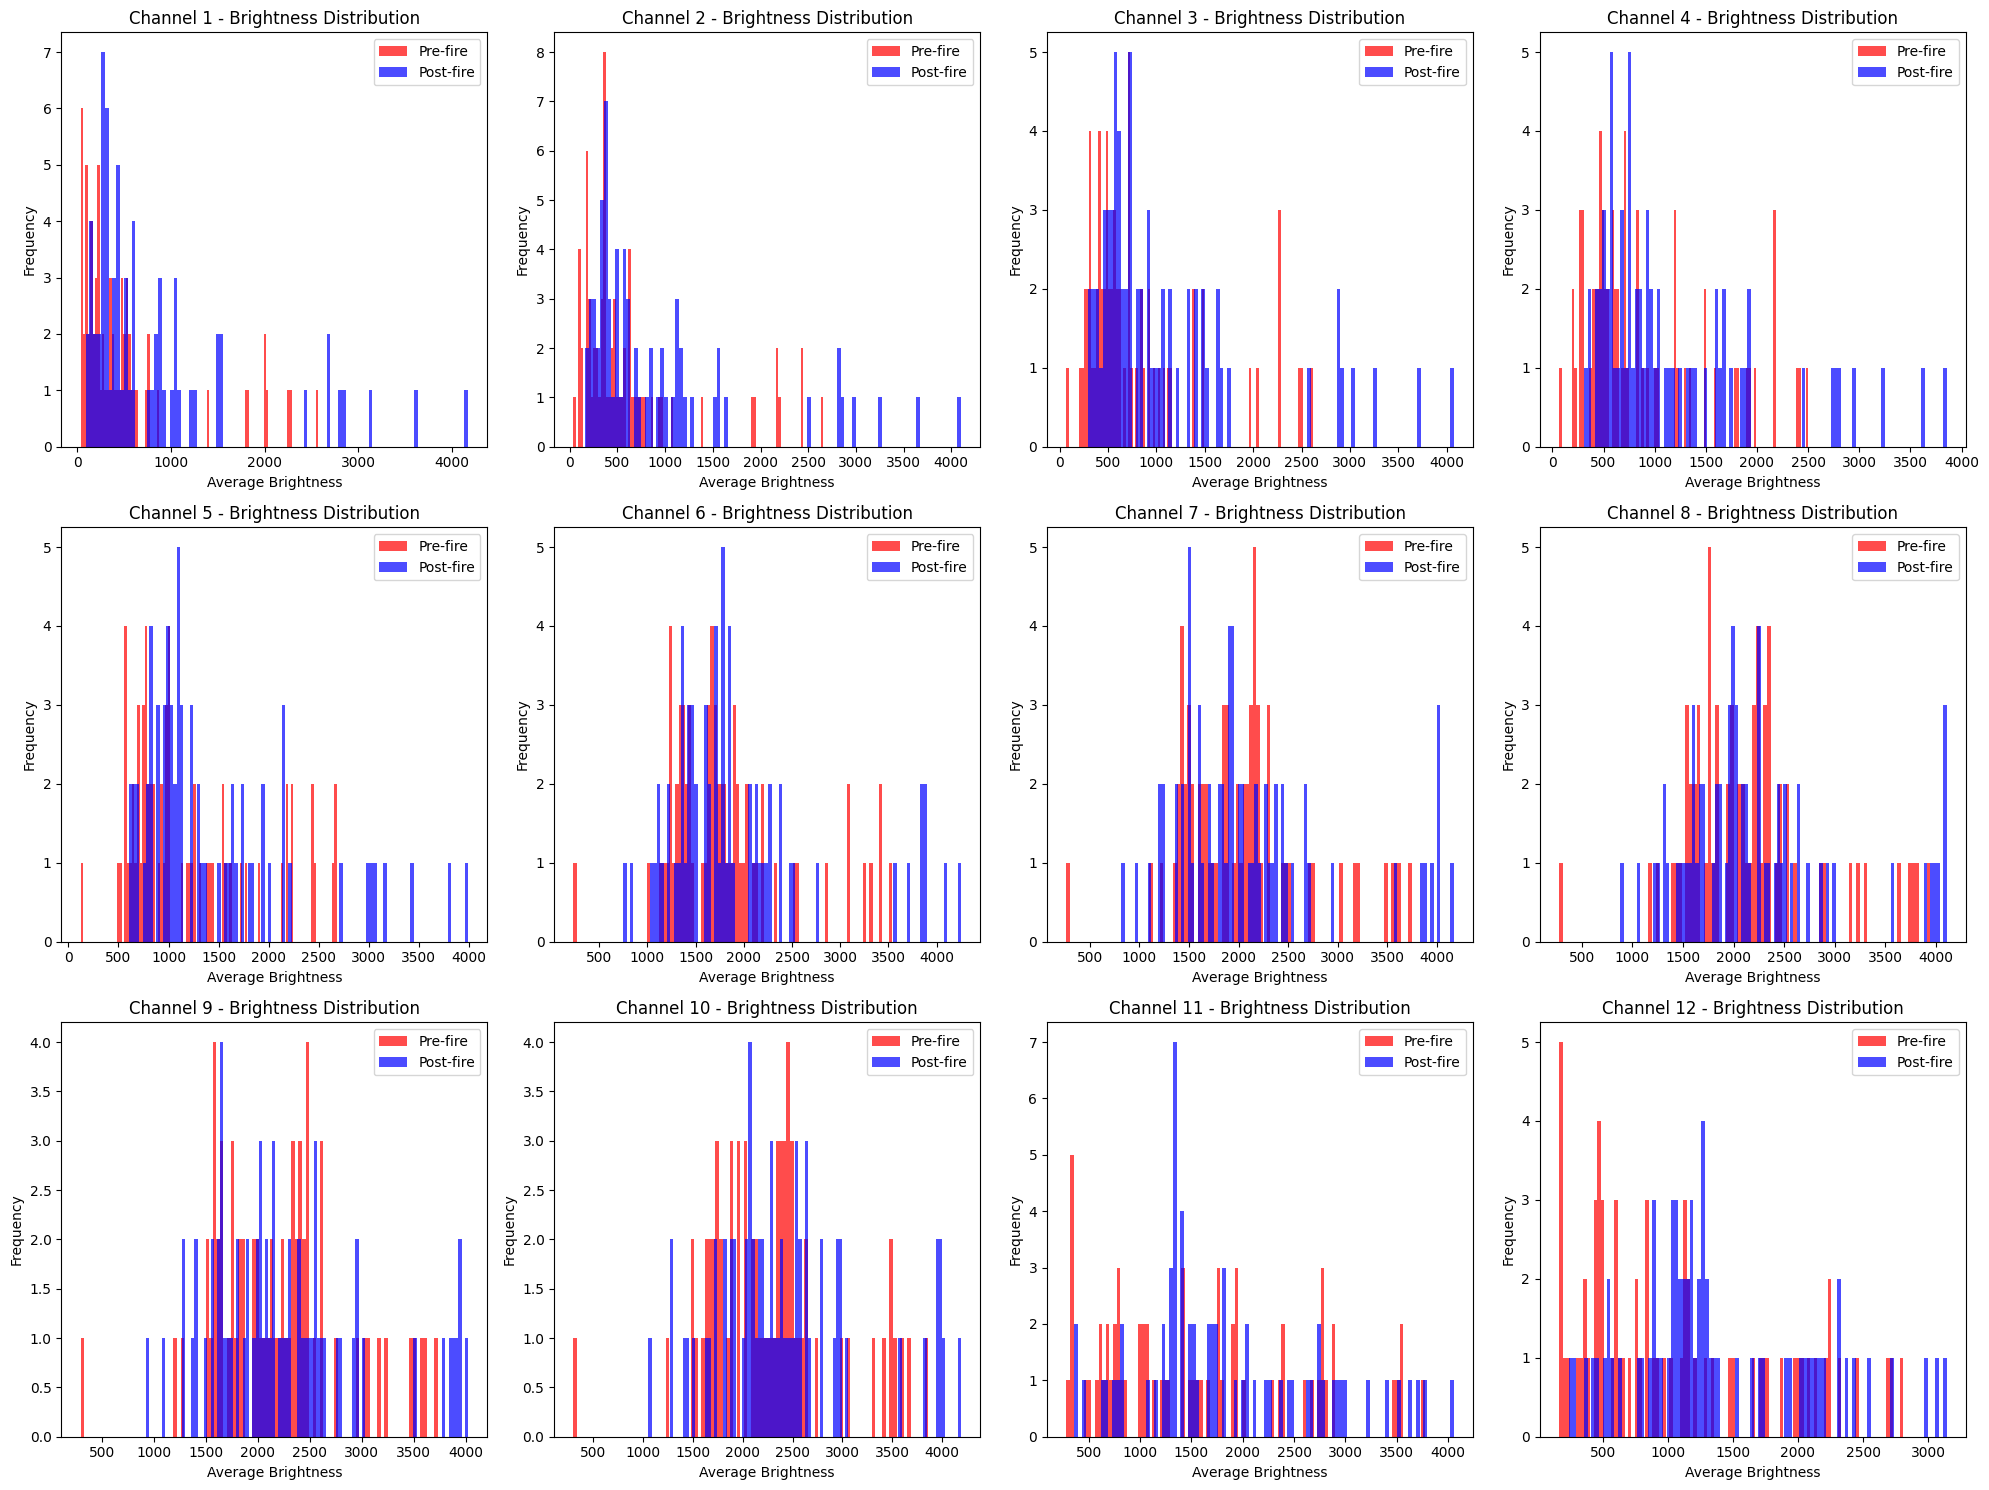

In [185]:
# arrays for saving data
pre_fire_brightness = []
post_fire_brightness = []

# go for all batch
for batch_idx, batch in enumerate(dataloader):

    pre_fire_images = batch['pre_fire']
    post_fire_images = batch['post_fire']

    # channels numb
    num_channels = pre_fire_images.size(1)

    # calculate averege brightness fro each image
    for i in range(pre_fire_images.size(0)): # chose image
        for channel in range(num_channels): # chose channel
            pre_fire_brightness.append(np.mean(pre_fire_images[i][channel].cpu().numpy()))
            post_fire_brightness.append(np.mean(post_fire_images[i][channel].cpu().numpy()))

# Create 12 graphics
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# gistogram for each channel
for channel in range(num_channels):
    # Choose average brightness pre_fire and post_fire images for current channel
    pre_brightness_channel = pre_fire_brightness[channel::num_channels]
    post_brightness_channel = post_fire_brightness[channel::num_channels]

    # Create gistogram for current channel
    ax = axes[channel]
    ax.hist(pre_brightness_channel, bins=100, color='r', alpha=0.7, label='Pre-fire')  # red gistogram for pre-fire
    ax.hist(post_brightness_channel, bins=100, color='b', alpha=0.7, label='Post-fire')  # blue гgistogram for post-fire
    
    ax.set_title(f'Channel {channel+1} - Brightness Distribution')
    ax.set_xlabel('Average Brightness')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()


судячи з графіків можемо зробити висновок, що Average Brightness для зображеннь pre-fire та post-fire в відповідних каналах є схожими, вони накладаються один на одного та здебільшого разом утровують одну вершину

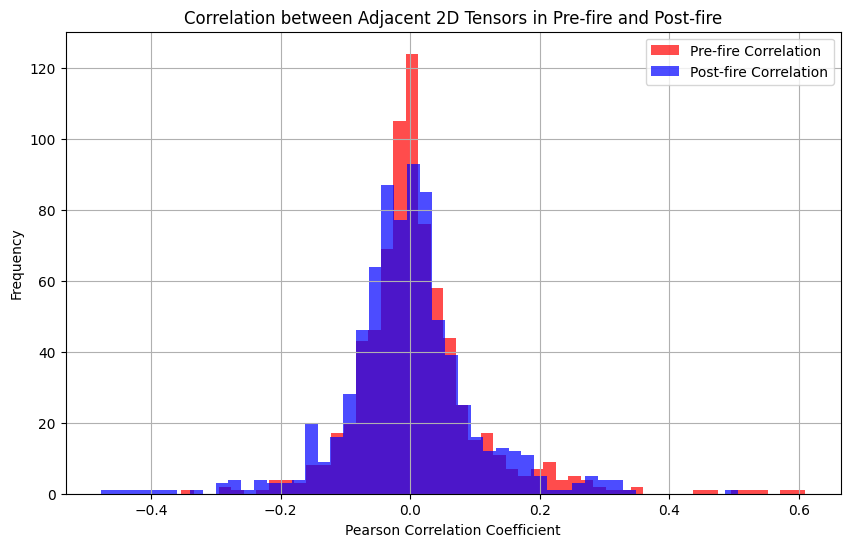

Average Correlation for Pre-fire: 0.0119
Average Correlation for Post-fire: -0.0034


In [186]:
# arrays for saving data
correlations_pre_fire = []
correlations_post_fire = []

# go for all batch
for batch_idx, batch in enumerate(dataloader):

    pre_fire_images = batch['pre_fire']
    post_fire_images = batch['post_fire']

     # channels numb
    num_channels = pre_fire_images.size(1)

    # check correlation with neibor images
    for channel in range(num_channels):
        for i in range(pre_fire_images.size(0) - 1):  # get all images
            # get 2 neibor tenzors for pre-fire і post-fire
            pre_fire_image_1 = pre_fire_images[i][channel].cpu().numpy().flatten() # Smoothing for correlation
            pre_fire_image_2 = pre_fire_images[i + 1][channel].cpu().numpy().flatten() # Smoothing for correlation
            post_fire_image_1 = post_fire_images[i][channel].cpu().numpy().flatten()  # Smoothing for correlation
            post_fire_image_2 = post_fire_images[i + 1][channel].cpu().numpy().flatten() # Smoothing for correlation

            # Calculate correlation between neibor images for pre-fire
            corr_pre, _ = pearsonr(pre_fire_image_1, pre_fire_image_2)
            correlations_pre_fire.append(corr_pre)

            # Calculate correlation between neibor images for post-fire
            corr_post, _ = pearsonr(post_fire_image_1, post_fire_image_2)
            correlations_post_fire.append(corr_post)


plt.figure(figsize=(10, 6))

# Gistogram for pre-fire
plt.hist(correlations_pre_fire, bins=50, color='r', alpha=0.7, label='Pre-fire Correlation')

# Gistogram for pre-fire post-fire
plt.hist(correlations_post_fire, bins=50, color='b', alpha=0.7, label='Post-fire Correlation')

plt.title('Correlation between Adjacent 2D Tensors in Pre-fire and Post-fire')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()

# Averege Correlation 
mean_corr_pre = np.mean(correlations_pre_fire)
mean_corr_post = np.mean(correlations_post_fire)

print(f"Average Correlation for Pre-fire: {mean_corr_pre:.4f}")
print(f"Average Correlation for Post-fire: {mean_corr_post:.4f}")


Ці значення кореляції дуже низькі (близькі до нуля), що вказує на слабкий або практично відсутній лінійний зв'язок між сусідніми зображеннями у нашому датасеті.



TypeError: Invalid shape (512,) for image data

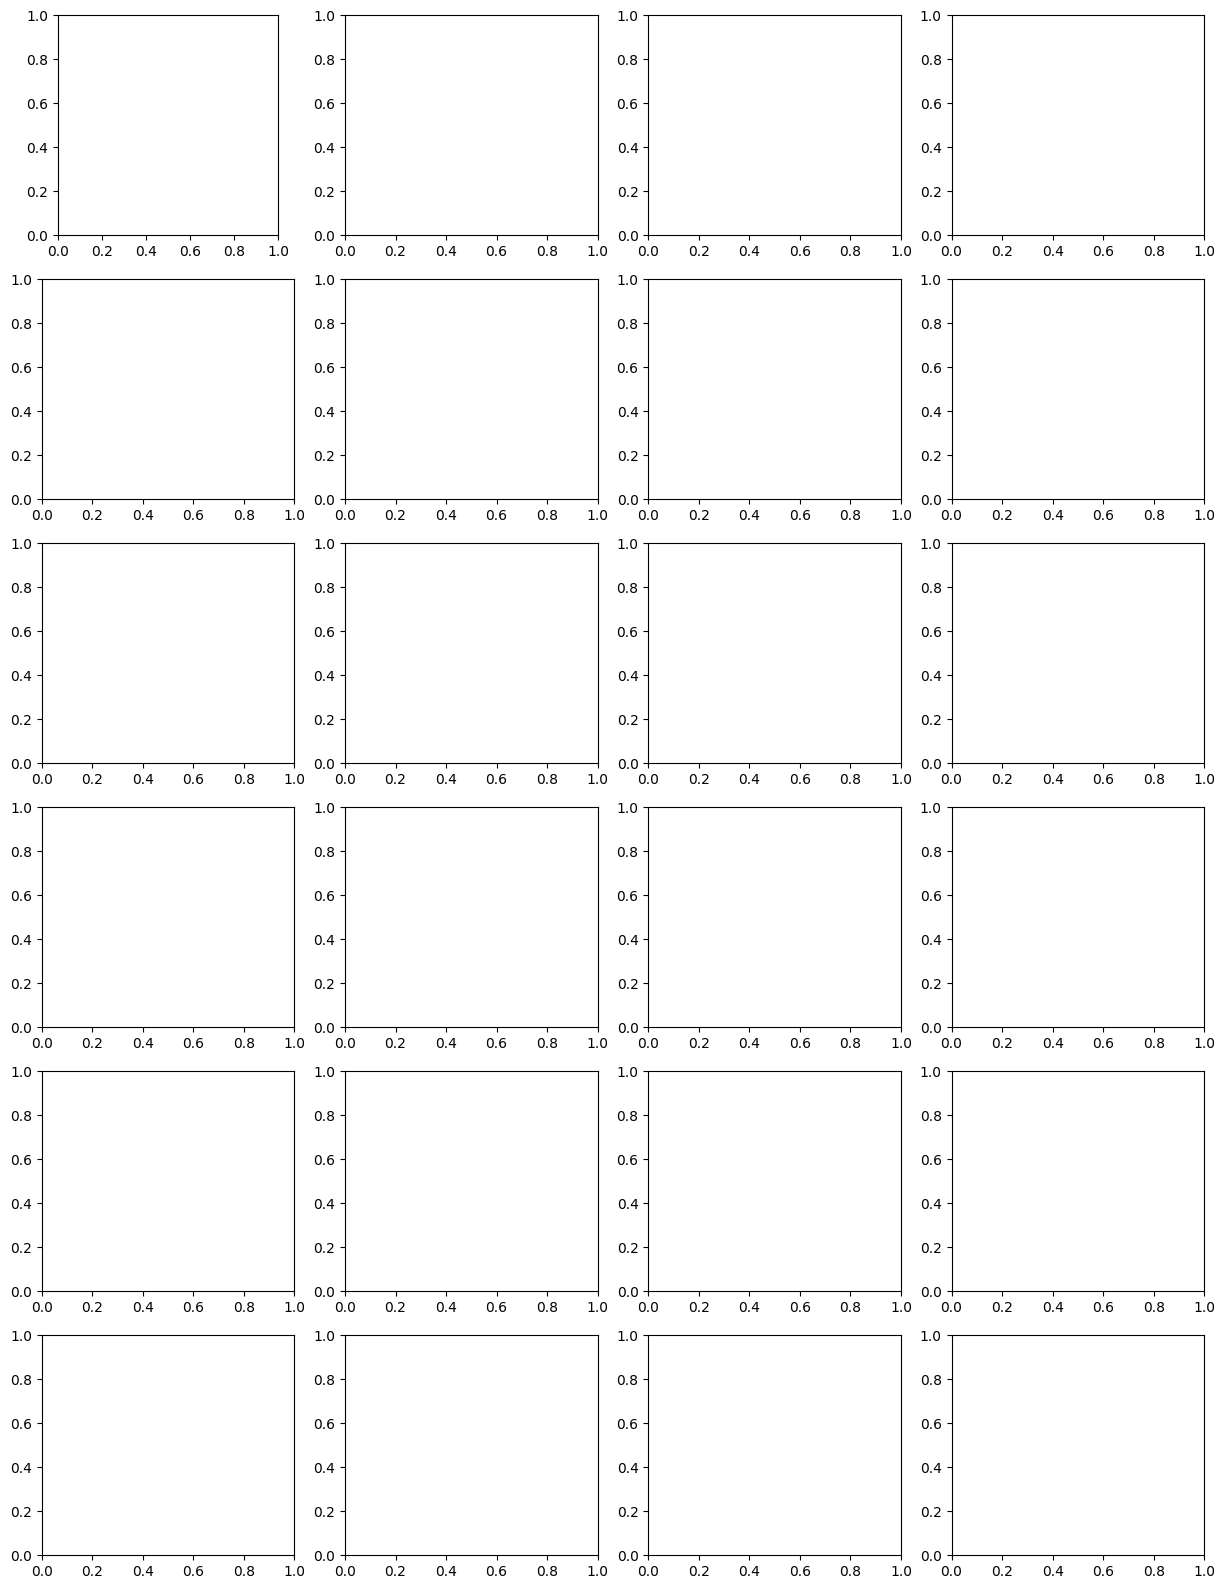

In [188]:
# Choose 12 images from the first batch for one channel
post_fire_images = batch['post_fire']
pre_fire_images = batch['pre_fire']
channel = 5

# Check if the batch has at least 12 images
batch_size = min(len(post_fire_images), 12)

# Create a plot with 6 rows and 4 columns
fig, axes = plt.subplots(6, 4, figsize=(15, 20))  # 6 rows, 4 columns

# Show 12 images with 1 channel from post_fire (first batch)
for i in range(batch_size):
    ax = axes[i // 4, i % 4]
    post_fire_image = post_fire_images[0][i][channel].cpu().numpy()  # Use the first batch only
    ax.imshow(post_fire_image, cmap='gray')
    ax.set_title(f'post_fire: Image {i + 1} (Channel {channel})')
    ax.axis('off')

# Show 12 images with 1 channel from pre_fire (first batch)
for i in range(batch_size):
    ax = axes[(i + batch_size) // 4, (i + batch_size) % 4]
    pre_fire_image = pre_fire_images[0][i][channel].cpu().numpy()  # Use the first batch only
    ax.imshow(pre_fire_image, cmap='gray')
    ax.set_title(f'pre_fire: Image {i + 1} (Channel {channel})')
    ax.axis('off')

plt.tight_layout()
plt.show()
